# CSE527 Homework 2
**Due date: 23:59 on October 29, 2023 (Sunday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org).

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 114 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 90% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all.

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

For Problem 3 you will train a small Vision Transformer (ViT) from scratch. ViT is pre-trained on large amounts of
data and transferred to multiple mid-sized or small image recognition benchmarks(ImageNet, CIFAR-100, VTAB, etc.), ViT attains excellent results compared to state-of-the-art convolutional networks.

There are 3 problems in this homework with a total of 100 points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/drive/folders/1-0wI50GfpXl3Dcxo2vjvItbnHMDdVurU?usp=drive_link) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.




In [140]:
# import packages here
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

In [141]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [142]:
# Set your working directory (in your google drive)
#   change it to your specific homework directory.
%cd '/content/gdrive/My Drive/CSE527/Avulapati_Anusha_115634631/'

/content/gdrive/My Drive/CSE527/Avulapati_Anusha_115634631


## Problem 0: Loading and Preprocessing data
---
In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing. Your will need to implement them when doing Problem 1.

In [249]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
# split data into train and test
def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False):
    data = []
    labels = []
    channel_num = 3 if is_color else 1

    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)

            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

            if is_color:
                img = np.transpose(img, [2, 0, 1])

            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float)/255*2-1)

    ##########--WRITE YOUR CODE HERE--##########
    # Data Augmentation
    if augment:
      aug_data = [cv2.flip(img, 1) for img in data]
      data.extend(aug_data)
      labels.extend(labels)
    ##########-------END OF CODE-------##########

    ##########--WRITE YOUR CODE HERE--##########
    # Data Normalization
    if zero_centered:
      for i in range(len(data)):
        mean, std = cv2.meanStdDev(data[i])
        data[i] = (data[i] - mean)
    ##########-------END OF CODE-------##########

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)

    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []

        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels

    return zip(batch_data, batch_labels)

class_names: {0: 'ostrya_virginiana', 1: 'smilax_glauca', 2: 'quercus_montana', 3: 'lonicera_maackii', 4: 'viola_striata', 5: 'lysimachia_nummularia', 6: 'phlox_divaricata', 7: 'rubus_phoenicolasius', 8: 'ranunculus_recurvatus', 9: 'vaccinium_stamineum', 10: 'liriodendron_tulipifera', 11: 'humulus_japonicus', 12: 'celastrus_orbiculatus', 13: 'campsis_radicans', 14: 'eupatorium_coalestinum', 15: 'glechoma_hederacea', 16: 'juniperis_virginiana', 17: 'ilex_opaca', 18: 'lindera_benzoin', 19: 'heliopsis_helianthoides', 20: 'asclepias_incarnata', 21: 'ailanthus_altissima'} 


In [250]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13


<ipython-input-249-65c2c2a916a4>:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(img.astype(np.float)/255*2-1)


Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 7 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 2 minibatches (batch_size=16)

ilex_opaca


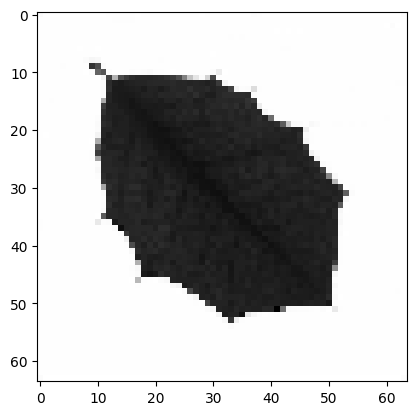

In [251]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch [40 points]
Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function (in this case, 16-way classification accuracy). Let's start!

First, let's define a simpe network architecture.

In [252]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()

      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
      )

      self.classifier = nn.Sequential(
         nn.Linear(3600, 22),
      )

    def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x


Then, let's define model training and evaluation functions.

In [253]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time

def trainModel(net, trainloader, train_option, testloader=None):
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1

  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()

  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))

    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)


In [254]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time

def evalModel(net, testloader):
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()

  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)

  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))


Finally, let's start training and evaluation.

In [255]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 0.001
train_option['epoch'] = 20
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.0663 | Average Loss: 3.0663 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8718 | Average Loss: 3.3121 
Accuracy: 0.187500 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7543 | Average Loss: 2.9870 
Accuracy: 0.437500 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.0411 | Average Loss: 2.7514 
Accuracy: 0.500000 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.6759 | Average Loss: 2.5544 
Accuracy: 0.593750 | Time: 00:00:00
Epoch: 6 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.5213 | Average Loss: 2.3735 
Accuracy: 0.593750 | Time: 00:00:00
Epoch: 7 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3018 | Average Loss: 2.2057 
Accuracy: 0.593750 | Time: 00:00:00
Epoch: 8 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.0487 | Average Loss: 2.0514 
Accuracy: 0.625000 | Time: 00:00:00
Epoch: 9 | Iter:    0 | Time: 00:00:00 |

You would get around 0.45-0.55 accuracy by this very simple network. Now it's your job to beat this result.

### Problem 1.1 [25 points]
Try to boost the accuracy by doing the following steps:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 114 original training images as much (because it sees 228 training images now, although they're not as good as 228 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. In this part, you are **required** to add dropout layer to your network.

**Please give detailed descriptions of your network layout in the following format:**<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
**Then report the final accuracy on test set.**

The reported accuracy required for this section should exceed **0.60**. As the dataset is small and there may be overfitting, your can report the **largest** accuracy achieved during training epoches.

In [256]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13


<ipython-input-249-65c2c2a916a4>:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(img.astype(np.float)/255*2-1)


Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 14 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 2 minibatches (batch_size=16

In [257]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()

      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
      )

      self.classifier = nn.Sequential(
         nn.Linear(3600, 22),
      )
      self.dropout = nn.Dropout(0.25)

    def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.dropout(x)
      x = self.classifier(x)
      return x

In [258]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 0.001
train_option['epoch'] = 20
train_option['device'] = 'gpu'
start_time = time.time()
trainModel(net, trainloader_small, train_option, testloader_small)
end_time = time.time()
total_time = end_time-start_time
print("Time taken for training is ")
print(total_time)



Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.1183 | Average Loss: 3.1183 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.4254 | Average Loss: 2.9738 
Accuracy: 0.468750 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.6453 | Average Loss: 2.6072 
Accuracy: 0.531250 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.2817 | Average Loss: 2.3132 
Accuracy: 0.500000 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.0375 | Average Loss: 2.0525 
Accuracy: 0.500000 | Time: 00:00:00
Epoch: 6 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.7532 | Average Loss: 1.8293 
Accuracy: 0.562500 | Time: 00:00:00
Epoch: 7 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.5726 | Average Loss: 1.6399 
Accuracy: 0.531250 | Time: 00:00:00
Epoch: 8 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.4264 | Average Loss: 1.4806 
Accuracy: 0.625000 | Time: 00:00:00
Epoch: 9 | Iter:    0 | Time: 00:00:00 |

Answer:

Data augmentation: True. Implemented horizontal image flipping to generate mirror images.

Data normalization: Conducted data normalization by calculating the mean and subtracting it, resulting in images being centered around zero.

Layer 1: In the Convolution Layer, employed 22 output channels with ReLU activation and incorporated max pooling.

Layer 2:In the Neural Network layer, utilized 3600 input nodes with a dropout rate of 0.25 and produced 22 output nodes.


...

Accuray on Test set: 0.68% | Time for Training: 0.57s | Time for Testing: 0.27s


## Problem 1.2 [15 points]

Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

The reported accuracy required for this section should exceed **0.70**. Your can report the **largest** accuracy achieved during training epoches.(At least **TWO** Technique should achieve this).

### Technique 1

In [102]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 18 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5


<ipython-input-5-65c2c2a916a4>:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(img.astype(np.float)/255*2-1)


Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 12 minibatches (batch_size=18) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images fr

In [103]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()

      self.layer1 = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
      )
      self.layer2 = torch.nn.Sequential(
        nn.Conv2d(64, 128, 3),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2),
      )

      self.classifier = nn.Sequential(
         nn.Linear(4608, 22),
      )
      self.dropout = nn.Dropout(0.5)

    def forward(self, x):
      x = self.layer1(x)
      print(x.size())
      x = self.layer2(x)
      x = torch.flatten(x, 1)
      x = self.dropout(x)
      x = self.classifier(x)
      return x


In [104]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 40
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

torch.Size([18, 64, 15, 15])
Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.2897 | Average Loss: 3.2897 
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
Accuracy: 0.027778 | Time: 00:00:00
torch.Size([18, 64, 15, 15])
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.9873 | Average Loss: 4.3016 
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([18, 64, 15, 15])
torch.Size([1

Answer:

Method 1: Model Modification with Activation Function


**Layer 1 - Convolution:**

Utilized nn.Conv2d(1, 64, 3) for the first layer.
Applied nn.ReLU() activation function.
Implemented nn.MaxPool2d(4, stride=4) for pooling.


**Layer 2 - Convolution:**

Employed nn.Conv2d(64, 128, 3) for the second layer.
Utilized nn.Sigmoid() as the activation function.
Included nn.MaxPool2d(2, stride=2) for pooling.

**Dense Neural Network:**

Introduced nn.Linear(4608, 22) for the fully connected layer.
Incorporated nn.Dropout(0.5) for regularization.

**Result:**


Accuracy on test data: **0.722222**(Best at Epoch 34). When compared with vanilla network , accuracy has been increased. The accuracy increased as a result of these modifications.

### Technique 2

In [81]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 28 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))


Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7


<ipython-input-5-65c2c2a916a4>:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(img.astype(np.float)/255*2-1)


Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 8 minibatches (batch_size=28) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images f

In [82]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()

      self.layer1 = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
      )
      self.layer2 = torch.nn.Sequential(
        nn.Conv2d(64, 128, 3),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2),
      )

      self.classifier1 = nn.Sequential(
         nn.Linear(4608, 1024),
         nn.BatchNorm1d(1024),
         nn.ReLU(),
      )
      self.classifier2 = nn.Sequential(
         nn.Linear(1024, 22),
      )

      self.dropout = nn.Dropout(0.25)

    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = torch.flatten(x, 1)
      x = self.dropout(x)
      x = self.classifier1(x)
      x = self.classifier2(x)
      return x



In [83]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 40
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.1333 | Average Loss: 3.1333 
Accuracy: 0.142857 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.4171 | Average Loss: 2.6261 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.6023 | Average Loss: 1.8666 
Accuracy: 0.321429 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.2771 | Average Loss: 1.4090 
Accuracy: 0.285714 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.1261 | Average Loss: 1.1163 
Accuracy: 0.500000 | Time: 00:00:00
Epoch: 6 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.0355 | Average Loss: 0.9138 
Accuracy: 0.535714 | Time: 00:00:00
Epoch: 7 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.0588 | Average Loss: 0.7733 
Accuracy: 0.642857 | Time: 00:00:00
Epoch: 8 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.0314 | Average Loss: 0.6692 
Accuracy: 0.678571 | Time: 00:00:00
Epoch: 9 | Iter:    0 | Time: 00:00:00 |

Answer:

Method 2: Adding more layers with batch normalisation

In second technique, network is strengthened by adding extra layers and employing batch normalization.

The first layer processes the image with a 3x3 filter, using batch normalization for stability. It applies the ReLU function and downsizes the image with max-pooling.

The second layer, similar in operation, utilizes more channels and Sigmoid activation. The dense neural network, with 4608 inputs and 22 outputs, ensures controlled learning.

These enhancements improve image understanding and model performance while maintaining stability during training.

Accuracy on test data: **0.75**(Best at Epoch 39). When compared with vanilla network of 0.68 , accuracy has been increased. The accuracy increased as a result of these modifications.

### Technique 3

In [72]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 28 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))


Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13


<ipython-input-5-65c2c2a916a4>:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(img.astype(np.float)/255*2-1)


Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 8 minibatches (batch_size=28) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 1 minibatches (batch_size=28)

In [73]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()

      self.layer1 = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.BatchNorm2d(64),
        nn.Tanh(),
        nn.MaxPool2d(4, stride=4),
      )
      self.layer2 = torch.nn.Sequential(
        nn.Conv2d(64, 128, 3),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2),
      )

      self.classifier1 = nn.Sequential(
         nn.Linear(4608, 1024),
         nn.BatchNorm1d(1024),
         nn.LeakyReLU(),
      )
      self.classifier2 = nn.Sequential(
         nn.Linear(1024, 22),
      )

      self.dropout = nn.Dropout(0.25)

    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = torch.flatten(x, 1)
      x = self.dropout(x)
      x = self.classifier1(x)
      x = self.classifier2(x)
      return x



In [74]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 40
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.1703 | Average Loss: 3.1703 
Accuracy: 0.071429 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.9280 | Average Loss: 2.6697 
Accuracy: 0.071429 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.0833 | Average Loss: 2.0047 
Accuracy: 0.392857 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.5729 | Average Loss: 1.6071 
Accuracy: 0.500000 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.4389 | Average Loss: 1.3273 
Accuracy: 0.535714 | Time: 00:00:00
Epoch: 6 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.2664 | Average Loss: 1.1202 
Accuracy: 0.607143 | Time: 00:00:00
Epoch: 7 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.1520 | Average Loss: 0.9656 
Accuracy: 0.571429 | Time: 00:00:00
Epoch: 8 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.0769 | Average Loss: 0.8431 
Accuracy: 0.642857 | Time: 00:00:00
Epoch: 9 | Iter:    0 | Time: 00:00:00 |

Answer:

Method 3: Different Activation functions - Using LeakyReLU() and Sigmoid()

I tried out two new activation functions in this model:

Leaky ReLU (Layer 1): In the first layer, I used Leaky ReLU. It allows some information from negative values, which can help the model learn better, especially in complex tasks.

Sigmoid (Layer 2): In the second layer, I used Sigmoid. It's great for tasks where we need to decide between two options or when we want to measure probabilities.

By testing these functions, I aimed to improve how the model works and adapts to different tasks.

Accuracy on test data: **0.75**(Best at Epoch 38). When compared with vanilla network of 0.68 , accuracy has been increased. The accuracy increased as a result of these modifications.

## Problem 2: Fine Tuning a Pre-Trained Deep Network [30 points]
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks.

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.


**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

### Problem 2.1 [10 points]

**Strategy A**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 22 classes) this is an attractive option. Fine-tuning can work far better than Strategy B of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

(30 points) You are required to implement Strategy A to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve accuracy of **0.90** approximately. The minimum accuracy required for this section is **0.80**.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

In [219]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True,
                                      augment=True, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8


<ipython-input-5-65c2c2a916a4>:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(img.astype(np.float)/255*2-1)


Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 14 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images

In [220]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------

import torchvision.models as models
alexnet =  models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [221]:
class Identity(nn.Module):
  def __init__(self):
    super(Identity,self).__init__()

  def forward(self,x):
    return x

class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()

      self.classifier = nn.Sequential(
          nn.Dropout(0.25),
          nn.Linear(9216, 4096),
          nn.BatchNorm1d(4096),
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(4096, 1024),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(1024,22),
      )

    def forward(self, x):
      x = self.classifier(x)
      return x

alexnet.avgpool = Identity()
alexnet.classifier = TNet()
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): Identity()
  (classifier): TNet(
    (classifier): Sequential(
      (0): Dropout(p=0.25, inplace=False)
      (1): Linear(in_features=9216, out_features=4096, bias=True)

In [262]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = alexnet
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
train_option['optimizer'] = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
start_time = time.time()
trainModel(net, trainloader_large, train_option, testloader_large)
end_time = time.time()
total_time = end_time-start_time
print("Time taken for training is ")
print(total_time)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.0005 | Average Loss: 0.0005 
Accuracy: 0.750000 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.2717 | Average Loss: 0.0993 
Accuracy: 0.812500 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.0001 | Average Loss: 0.1191 
Accuracy: 0.656250 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:01 | Train Loss: 0.0000 | Average Loss: 0.1406 
Accuracy: 0.593750 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:01 | Train Loss: 0.5165 | Average Loss: 0.1386 
Accuracy: 0.656250 | Time: 00:00:00
Epoch: 6 | Iter:    0 | Time: 00:00:01 | Train Loss: 0.9083 | Average Loss: 0.1680 
Accuracy: 0.500000 | Time: 00:00:00
Epoch: 7 | Iter:    0 | Time: 00:00:01 | Train Loss: 0.6522 | Average Loss: 0.2355 
Accuracy: 0.625000 | Time: 00:00:00
Epoch: 8 | Iter:    0 | Time: 00:00:02 | Train Loss: 0.0751 | Average Loss: 0.2722 
Accuracy: 0.562500 | Time: 00:00:00
Epoch: 9 | Iter:    0 | Time: 00:00:02 |

Answer:

(1) which layers of AlexNet have been replaced

The modifications to AlexNet involved replacing the Global Average Pooling (GAP) layer to align with the scene classification task's specific number of output classes. Additionally, the last three fully connected classifier layers from the original AlexNet were substituted with a new classifier architecture.




(2) the architecture of the new layers added including activation methods (same as problem 1)

Data augmentation and Data normalization : Data augmentation and normalization methods have been applied during data preprocessing.

Classifier Layer 1: The first fully connected layer has 4096 units, followed by Batch Normalization and ReLU activation.

Classifier Layer 2: The second fully connected layer has 1024 units with a ReLU activation function.

Classifier Layer 3: The final fully connected layer has 22 units, corresponding to the 22 output classes.

...

(3) the final accuracy on test set along with time consumption for both training and testing

Accuracy on Test set: **0.875000** | Time for Training: 6.51s | Time for Testing: 3s




### Problem 2.2 [10 points]
**Strategy B**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 1000 activations.

(20 points) Implement Strategy B where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing. You should be able to achieve accuracy of **0.85** approximately. The minimum accuracy required for this section is **0.75**.

In [205]:
def get_features(model , dataset):
  activation = {}
  train_feat = None
  train_labels = None
  def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

  model.classifier[5].register_forward_hook(get_activation('ReLU_layer'))

  model = model.cuda()
  for iter, (x, y) in enumerate(dataset):
    batch_x = Variable(x).float()
    batch_y = Variable(y).long()
    batch_x = batch_x.cuda()
    batch_y = batch_y.cuda()

    outputs = model(batch_x)
    if train_feat is None :
      train_feat = activation['ReLU_layer'][:,:1000]
      train_labels = batch_y
    else :
      train_feat = torch.vstack((train_feat, activation['ReLU_layer'][:,:1000]))
      train_labels = torch.vstack((train_labels,batch_y))

  train_labels = train_labels.view(-1,1)

  return train_feat, train_labels



In [206]:
def convert_to_numpy(x):
    return x.detach().cpu().numpy()

In [207]:
#--------------------------------------------------
#       Get Features from AlexNet
#--------------------------------------------------
import torchvision.models as models

model = models.alexnet(pretrained=True)


train_feat, train_label = get_features(model, trainloader_large)
test_feat, test_label =  get_features(model, testloader_large)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [208]:
train_feat, train_label = convert_to_numpy(train_feat) ,convert_to_numpy(train_label).ravel()
test_feat, test_label = convert_to_numpy(test_feat) ,convert_to_numpy(test_label).ravel()

In [209]:
print(train_label.shape)

(224,)


In [260]:
#--------------------------------------------------
#       Train and Evaluate SVM
#--------------------------------------------------
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

start_time = time.time()

clf = OneVsOneClassifier(LinearSVC(random_state=0)).fit(train_feat, train_label)
total_time = time.time()-start_time

print(f"Training SVM model has taken {total_time: .2f}")

Training SVM model has taken  0.32


In [261]:
start_time = time.time()
# make predictions on test data
predictions = [-1]*len(test_feat)
for i in range(len(test_feat)):
  predictions[i] = clf.predict(np.reshape(test_feat[i],(1,-1)))

test_label_pred = np.reshape(np.array(predictions),(-1,))
accuracy = sum(np.array(test_label_pred) == test_label) / float(len(test_label))
total_time = time.time()-start_time
print("The accuracy of one-vs-all SVMs model is {:.2f}%".format(accuracy*100))
print(f"Testing data on SVM Model has taken {total_time: .2f}")

The accuracy of one-vs-all SVMs model is 87.50%
Testing data on SVM Model has taken  1.49


Answer:

Accuracy on Test set: **87.50%** | Time for Training: 0.32s | Time for Testing: 1.49s

### Problem 2.3 [10 points]

Now fine-tune the [ResNet network](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html) [(paper)](https://arxiv.org/abs/1512.03385) and compare performance with AlexNet. **Explain** why ResNet performed better or worse. You are **required** to use **resnet50** model. You should be able to achieve accuracy of **0.99** approximately. The minimum accuracy required for this section is **0.85**.

In [268]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
import torchvision.models as models
model = models.resnet50(pretrained=True)

In [269]:
model.fc = nn.Sequential(nn.BatchNorm1d(2048),
                         nn.Dropout(0.5),
                         nn.Linear(2048,1000,bias=True),
                         nn.ReLU(),
                         nn.Linear(1000,22))


In [271]:
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
train_option['optimizer'] = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
start_time = time.time()
trainModel(model, trainloader_large, train_option, testloader_large)
end_time = time.time()
total_time = end_time-start_time
print("Time taken for training is ")
print(total_time)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.0188 | Average Loss: 0.0188 
Accuracy: 0.906250 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:02 | Train Loss: 0.0007 | Average Loss: 0.0223 
Accuracy: 0.906250 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:05 | Train Loss: 0.0007 | Average Loss: 0.0128 
Accuracy: 0.906250 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:07 | Train Loss: 0.0003 | Average Loss: 0.0088 
Accuracy: 0.906250 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:10 | Train Loss: 0.0002 | Average Loss: 0.0068 
Accuracy: 0.906250 | Time: 00:00:00
Epoch: 6 | Iter:    0 | Time: 00:00:12 | Train Loss: 0.0003 | Average Loss: 0.0055 
Accuracy: 0.906250 | Time: 00:00:00
Epoch: 7 | Iter:    0 | Time: 00:00:14 | Train Loss: 0.0001 | Average Loss: 0.0047 
Accuracy: 0.906250 | Time: 00:00:00
Epoch: 8 | Iter:    0 | Time: 00:00:17 | Train Loss: 0.0002 | Average Loss: 0.0040 
Accuracy: 0.906250 | Time: 00:00:00
Epoch: 9 | Iter:    0 | Time: 00:00:19 |

Answer:

ResNet surpasses AlexNet primarily because of its enhanced depth, featuring an impressive 50-layer architecture. This extended depth empowers ResNet to capture finer and more complex data features. Moreover, ResNet harnesses batch normalization at multiple stages within its network structure, enhancing the training process's smoothness and efficiency. Additionally, ResNet effectively tackles the vanishing gradient issue by introducing skip connections, allowing gradients to flow through the network's extensive layers.

Accuracy on Test set: **0.906250** | Time for Training: 49.34s | Time for Testing: 35.2s

When compared with Alexnet of accuracy 0.87 , in this technique(ResNet) accuracy is 0.90, accuracy has been increased by 0.3.


### Problem 3 Transformer [30 points]
In this section you are supposed to build a Vision Transformer (ViT). Transformer has achieved significant success in the field of Natural Language Processing, such as machine translation. ViT explores how to utilize transformer into computer vision tasks and attains excellent results compared to state-of-the-art convolutional networks.

Transformer paper: https://arxiv.org/pdf/1706.03762.pdf

Transformer tutorial: http://jalammar.github.io/illustrated-transformer/

ViT paper: https://openreview.net/pdf?id=YicbFdNTTy

ViT tutorial: https://www.youtube.com/watch?v=HZ4j_U3FC94




First you will build a Transformer Encoder Layer. ViT consists of multiple transformer encoder layers (i.e. the left block of the following image). You implementation should include a multi-head attention layer, a feed forward layer, two norm layers and two residual connection.

<img src="https://production-media.paperswithcode.com/method_collections/trans.jpeg" width="400">

In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embedding_dims=128, dropout=0.1, mlp_hidden_dim=32, num_heads=2):
        super().__init__()
        self.multihead_self_attn = nn.MultiheadAttention(embed_dim=embedding_dims, num_heads=num_heads, dropout=dropout) # Multi-Head Self-Attention Layer
        self.norm1 = nn.LayerNorm(embedding_dims) # Layer Normalization
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dims, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embedding_dims),
        )
        self.norm2 = nn.LayerNorm(embedding_dims) # Layer Normalization
        self.dropout = nn.Dropout(dropout) # Dropout

    def forward(self, x):
        attained_output, _ = self.multihead_self_attn(x, x, x)
        x = self.norm1(x + attained_output) # Residual Connection and Layer Normalization
        feed_forward_output = self.feed_forward(x) # Feed Forward Layer
        x = self.norm2(x + feed_forward_output) # Residual Connection and Layer Normalization
        x = self.dropout(x) # Apply Dropout
        return x

<img src=https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png width="400">

Then you can start a Vision Transformer. Your ViT should consist:


**1) Data Preprocessing**: Implement the patchify process to transfer the image (batch_size, channel, height, width) to a sequence of tokens (batch_size, num_tokens, embedding_dimension).


**2) Positional Encoding**

**3) Extra Learnable [CLASS] embedding**

**4) Transformer Encoder**: Construct a transformer encoder by TransformerEncoderLayer you have already built.

**5) Prediction**: Build the MLP Head and make classification.

Train your ViT on MNIST and
 - report the test accuracy
 - save your ViT model in a checkpoint file named: **./vit_trained.pt**  

The reported accuracy required for this section should exceed **0.70**.

In [143]:
class ViT(nn.Module):
    def __init__(self, img_size=64, in_channels=1, patch_size=16, embedding_dims=128,
                 num_transformer_layers=2, dropout=0.1, mlp_hidden_dim=128, num_heads=2, num_classes=10):
        super().__init__()

        self.num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        self.patch_layer_embedded = nn.Conv2d(in_channels, embedding_dims, kernel_size=patch_size, stride=patch_size) # Patch Embedding Layer
        self.position_embedding_layer = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dims)) # Positional Embedding
        self.transformer_layers_encoder = nn.ModuleList([
            TransformerEncoderLayer(embedding_dims, dropout, mlp_hidden_dim, num_heads) for _ in range(num_transformer_layers)
        ]) # Transformer Encoder Layers
        self.classic_head = nn.Linear(embedding_dims, num_classes) # Classification Head
        self.dropout = nn.Dropout(dropout) # Dropout Layer

    def forward(self, x):
        x = self.patch_layer_embedded(x) # Extract patches from the input image
        x = x.view(x.size(0), -1, x.size(1)) # Reshape to flatten patches
        x = x + self.position_embedding_layer # Add positional embedding
        x = self.dropout(x) # Apply dropout
        # Pass through the Transformer Encoder layers
        for layer in self.transformer_layers_encoder:
            x = layer(x)

        # Global Average Pooling
        x = x.mean(dim=1)
        x = x.view(x.size(0), -1)

        # Classification Head
        x = self.classic_head(x)

        return x

In [144]:
#load MNIST dataset
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Load MNIST dataset
transform = ToTensor()
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

In [145]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
def trainVitModel(model, train_loader, train_option, test_loader):
    cross_entropy = nn.CrossEntropyLoss()
    train_optimizer = train_option['optimizer']
    device = train_option['device']
    train_epochs = train_option['epoch']

    model.to(device)
    model.train()

    for epoch in range(train_epochs):
        loss_leakage = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            train_optimizer.zero_grad()

            img_outputs = model(inputs)
            loss = cross_entropy(img_outputs, labels)
            loss.backward()
            train_optimizer.step()

            loss_leakage += loss.item()

        print(f"Epoch [{epoch + 1}/{train_epochs}] - Loss: {loss_leakage / len(train_loader)}")

# Define and train the ViT model
vit_model = ViT()
train_option = {
    'lr': 0.002,
    'epoch': 20,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'optimizer': optim.Adam(vit_model.parameters(), lr=0.002)
}
trainVitModel(vit_model, train_loader, train_option, test_loader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Evaluation
vit_model.eval()
right = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images)
        _, total_predicted = torch.max(outputs, 1)
        total += labels.size(0)
        right += (total_predicted == labels).sum().item()

accuracy_in_test = right / total
print(f"Test Accuracy: {accuracy_in_test * 100:.2f}%")

# Save the model checkpoint
torch.save(model.state_dict(), "./vit_trained.pt")




Epoch [1/20] - Loss: 0.6321107027118903
Epoch [2/20] - Loss: 0.3988138565948523
Epoch [3/20] - Loss: 0.3479780609101883
Epoch [4/20] - Loss: 0.32364890805439656
Epoch [5/20] - Loss: 0.30830748995611157
Epoch [6/20] - Loss: 0.29332988680616373
Epoch [7/20] - Loss: 0.28168975468129237
Epoch [8/20] - Loss: 0.26960919479698514
Epoch [9/20] - Loss: 0.2634118850837384
Epoch [10/20] - Loss: 0.25400012939660027
Epoch [11/20] - Loss: 0.24791599800591785
Epoch [12/20] - Loss: 0.23971978076167708
Epoch [13/20] - Loss: 0.23584704464877337
Epoch [14/20] - Loss: 0.23244005502032827
Epoch [15/20] - Loss: 0.2273744212856679
Epoch [16/20] - Loss: 0.22160944971702753
Epoch [17/20] - Loss: 0.21610857117404816
Epoch [18/20] - Loss: 0.21174327092670175
Epoch [19/20] - Loss: 0.2091614921559403
Epoch [20/20] - Loss: 0.20780490643815444
Test Accuracy: 91.08%


## Submission guidelines
---
Download the .ipynb file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw2' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the *dataset* on brightspace due to size limit.

When submitting your .zip file through brightspace, please
-- name your .zip file as **Surname_Givenname_SBUID_hw2.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
        |---vit_trained.pt
```

For instance, student Yann LeCun should submit a zip file named "LeCun_Yann_111134567_hw2.zip" for homework2 in this structure:
```
LeCun_Yann_111134567_hw2
        |---LeCun_Yann_111134567_hw2.ipynb
        |---LeCun_Yann_111134567_hw2.pdf
        |---vit_trained.pt
```

The **Surname_Givenname_SBUID_hw*.pdf** should only include a **google shared link**. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter TA's emails: **ruoyu.xue@stonybrook.edu**. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard.

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

<!--Write your report here in markdown or html-->
